In [2]:

import gc
import os
import random
import numpy as np
import torch
from transformers import CLIPModel, CLIPProcessor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

%matplotlib inline



CONFIG


In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
seed = 100
set_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Dataset


In [4]:

extractor_model_ref = "openai/clip-vit-base-patch32"
extractor_model = CLIPModel.from_pretrained(extractor_model_ref)
extractor_processor = CLIPProcessor.from_pretrained(extractor_model_ref)


In [5]:
dataset = load_dataset("fashion_mnist")
img_size = (64, 64)
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)
    ]
)


def mnist_transforms(examples):
    examples["pixel_values"] = [
        transform(image.convert("L")) for image in examples["image"]
    ]
    del examples["image"]

    return examples


Found cached dataset fashion_mnist (/media/master/text/cv_data/hf_home/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [13]:


class DCDatasetCustom:
    def __init__(
        self,
        include_cond_image=False,
        sdm_transform=None,
        dataset=None,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.include_cond_image = include_cond_image
        self.default_transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.sdm_transform = sdm_transform or self.default_transform
        self.max_depth = 80

        if dataset is not None:
            self.train_dataset = dataset.with_transform(
                mnist_transforms
            ).remove_columns("label")

    def __getitem__(self, idx):

        img = self.train_dataset[idx]
        img = transforms.Resize((128,128))(img["pixel_values"][0].unsqueeze(0))
        cond_image = torch.load("cond_image.pt")

        pixel_values = extractor_processor(
            images=torch.stack(
                [
                    torch.from_numpy(np.array(cond_image)),
                    torch.from_numpy(np.array(cond_image)),
                ]
            ),
            return_tensors="pt",
        ).pixel_values
        embedding = extractor_model.get_image_features(pixel_values=pixel_values)
        embedding = embedding.unsqueeze(1).to(device)
        encoding = embedding[0]
        mask = torch.ones(1).bool().to(device)

        sample = {
            "image": img.detach(),
            "encoding": encoding.detach(),
            "mask": mask.detach(),
        }
        if self.include_cond_image:
            sample["cond_image"] = cond_image.detach()
        return sample


ds = DCDatasetCustom(
    include_cond_image=True,
    dataset=dataset["train"],
)


In [14]:
x = ds[0]
x["image"].shape, x["encoding"].shape, x["mask"].shape

/home/master/.conda/envs/ssdc/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([1, 128, 128]), torch.Size([1, 512]), torch.Size([1]))

In [15]:
images = x["image"].unsqueeze(0).to(device)
cond_images = x["cond_image"].unsqueeze(0).to(device)
text_embeds = x["encoding"].unsqueeze(0).to(device)
text_masks=x["mask"].unsqueeze(0).to(device)

In [36]:
from imagen_pytorch import Unet, Imagen

gc.collect()
torch.cuda.empty_cache()

unet1 = Unet(
    dim=32,
    cond_dim=512,
    dim_mults=(1, 2, 4, 8),
    num_resnet_blocks=3,
    channels=1,
    layer_attns=(False, True, True, True),
    layer_cross_attns=(False, True, True, True),
    text_embed_dim=512,
    cond_on_text=False,
    # cond_images_channels=3,
)

unet2 = Unet(
    dim=32,
    cond_dim=512,
    dim_mults=(1, 2, 4, 8),
    num_resnet_blocks=(2, 4, 8, 8),
    layer_attns=(False, False, False, True),
    layer_cross_attns=(False, False, False, True),
    text_embed_dim=512,
    cond_on_text=False,
    # cond_images_channels=3,
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    # unets=(unet1,),
    # image_sizes=(128),
    channels=1,
    unets = (unet1, unet2),
    image_sizes = (64, 128),
    timesteps=200,
    cond_drop_prob=0.1,
    text_embed_dim=512,
    condition_on_text = False,
    pred_objectives='x_start'
    # only_train_unet_number=1
).cuda()

optimizer = torch.optim.Adam(imagen.parameters(), lr=5e-4)

Input

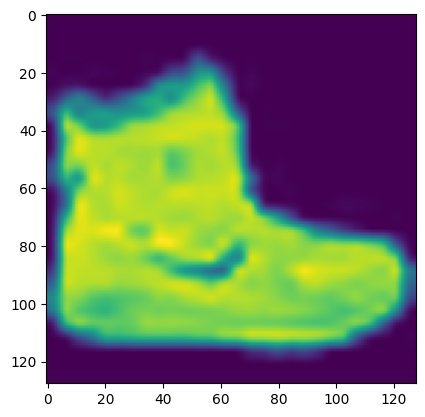

In [38]:
plt.imshow(x["image"].permute(1, 2, 0).cpu().detach().numpy())

epoch 0
loss_1 0.05819350853562355
loss_2 10.343371391296387


0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

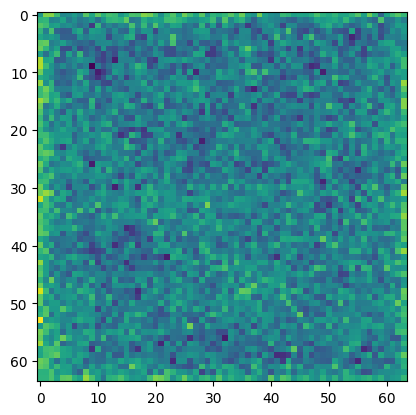

epoch 1
loss_1 7.515475273132324
loss_2 21.94843101501465
epoch 2
loss_1 21.032514572143555
loss_2 20.339567184448242
epoch 3
loss_1 19.454608917236328
loss_2 17.97979164123535
epoch 4
loss_1 17.451602935791016
loss_2 14.632436752319336
epoch 5
loss_1 0.9491913318634033
loss_2 0.9228979349136353
epoch 6
loss_1 11.877823829650879
loss_2 0.41994497179985046
epoch 7
loss_1 7.973345756530762
loss_2 4.349320411682129
epoch 8
loss_1 5.522985935211182
loss_2 0.9340224266052246
epoch 9
loss_1 0.9014005064964294
loss_2 2.354240894317627
epoch 10
loss_1 1.6126620769500732
loss_2 0.3538264334201813
epoch 11
loss_1 3.117243977612816e-05
loss_2 0.4049631655216217
epoch 12
loss_1 5.670487880706787
loss_2 0.18824398517608643
epoch 13
loss_1 0.13952170312404633
loss_2 0.33384573459625244
epoch 14
loss_1 0.0480259545147419
loss_2 0.01230042427778244
epoch 15
loss_1 0.013234690763056278
loss_2 0.4834713637828827
epoch 16
loss_1 0.018802622333168983
loss_2 0.03813214600086212
epoch 17
loss_1 0.0795128494

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

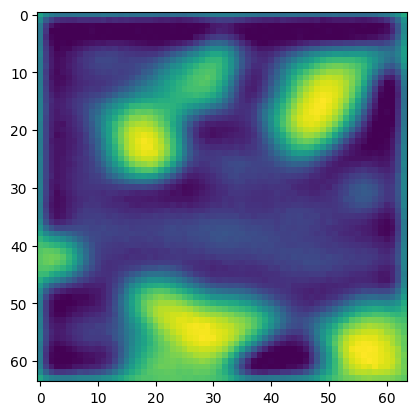

epoch 31
loss_1 0.958142876625061
loss_2 0.14299778640270233
epoch 32
loss_1 0.4119357466697693
loss_2 0.018522223457694054
epoch 33
loss_1 0.7597759366035461
loss_2 1.3960602283477783
epoch 34
loss_1 0.2068818062543869
loss_2 0.7650895714759827
epoch 35
loss_1 0.9456993341445923
loss_2 0.5674450397491455
epoch 36
loss_1 0.06320586800575256
loss_2 0.13521215319633484
epoch 37
loss_1 0.9156879186630249
loss_2 0.08881643414497375
epoch 38
loss_1 0.08220881968736649
loss_2 0.8484941720962524
epoch 39
loss_1 0.608086109161377
loss_2 0.007115157321095467
epoch 40
loss_1 0.6657523512840271
loss_2 0.7696126699447632
epoch 41
loss_1 0.6465805768966675
loss_2 0.09568870067596436
epoch 42
loss_1 0.6617348790168762
loss_2 0.30185291171073914
epoch 43
loss_1 0.1302565038204193
loss_2 0.41890934109687805
epoch 44
loss_1 0.20769387483596802
loss_2 0.150130033493042
epoch 45
loss_1 0.5507572889328003
loss_2 0.029217788949608803
epoch 46
loss_1 0.03403202071785927
loss_2 0.0277483519166708
epoch 47
lo

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

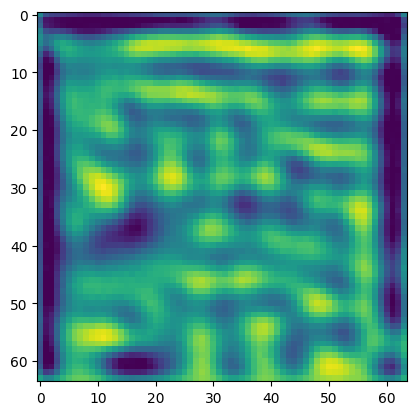

epoch 61
loss_1 0.02949056588113308
loss_2 0.029288165271282196
epoch 62
loss_1 0.05978533998131752
loss_2 0.06077708303928375
epoch 63
loss_1 0.3926388919353485
loss_2 0.03766356036067009
epoch 64
loss_1 0.06776778399944305
loss_2 0.014551285654306412
epoch 65
loss_1 0.01621042750775814
loss_2 0.9398810863494873
epoch 66
loss_1 0.4305539131164551
loss_2 0.022387217730283737
epoch 67
loss_1 0.2761353850364685
loss_2 0.050939321517944336
epoch 68
loss_1 0.13932780921459198
loss_2 0.049043796956539154
epoch 69
loss_1 0.0326237715780735
loss_2 0.4613006114959717
epoch 70
loss_1 0.40710940957069397
loss_2 0.3638384938240051
epoch 71
loss_1 0.10940014570951462
loss_2 0.09545691311359406
epoch 72
loss_1 0.2196522057056427
loss_2 0.36484017968177795
epoch 73
loss_1 0.3297215700149536
loss_2 0.6158064603805542
epoch 74
loss_1 0.09433118253946304
loss_2 0.06307677179574966
epoch 75
loss_1 0.3963322043418884
loss_2 7.821503095328808e-05
epoch 76
loss_1 0.1310272067785263
loss_2 0.022770406678318

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

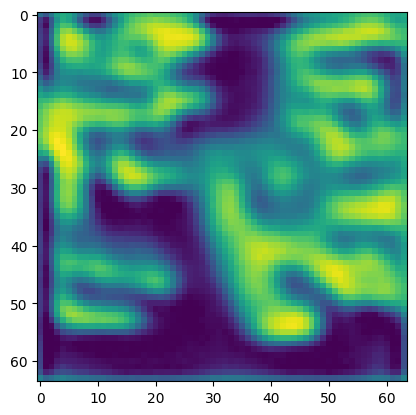

epoch 91
loss_1 0.07297932356595993
loss_2 0.26020926237106323
epoch 92
loss_1 0.2013387233018875
loss_2 0.061388205736875534
epoch 93
loss_1 0.5453532338142395
loss_2 0.10398425906896591
epoch 94
loss_1 0.3662886619567871
loss_2 0.02136768214404583
epoch 95
loss_1 0.3157773017883301
loss_2 0.006400390062481165
epoch 96
loss_1 0.019847802817821503
loss_2 0.10560246556997299
epoch 97
loss_1 0.13152681291103363
loss_2 0.1501961350440979
epoch 98
loss_1 0.3816029131412506
loss_2 0.11059685796499252
epoch 99
loss_1 0.04824146255850792
loss_2 0.2568855881690979


In [37]:
for epoch in range(100):
    optimizer.zero_grad()
    print(f'epoch {epoch}')
    for i in range(1,3):
        loss = imagen(images, 
                    #   text_embeds=text_embeds, 
                    #   cond_images=cond_images,
                      unet_number=i)
        loss.backward()
        print(f'loss_{i} {loss.item()}')
    optimizer.step()

    if epoch % 30 == 0:

        samples = imagen.sample(
            # text_embeds=text_embeds,
            # text_masks=text_masks,
            cond_scale=0.0,
            # cond_images=cond_images,
            stop_at_unet_number=1,
        )

        plt.imshow(samples[0].permute(1, 2, 0).cpu().detach().numpy())
        plt.show()